In [111]:
#Importing the basic librarires

import os
import math
import scipy
from time import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from scipy.spatial.distance import cdist
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import sklearn.metrics as metrics

from mpl_toolkits.mplot3d import Axes3D # 3d plot
from termcolor import colored as cl

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

# 1. Data Exploration

In [2]:
df=pd.read_excel('C:\\Users\\david\\Desktop\\Online Retail.xlsx')

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Inference: The Datset consists of 8 features & 541909 samples.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df_s = df.sample(10000, random_state=42)
df_s["InvoiceDate"] = df_s["InvoiceDate"].dt.date
df_s["TotalSum"] = df_s["Quantity"] * df_s["UnitPrice"]
snapshot_date = max(df_s.InvoiceDate) + datetime.timedelta(days=1)
customers = df_s.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)
#customers = customers[customers.MonetaryValue>0]
display(customers.head())

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,5,81.60
12349.0,19,1,19.90
12353.0,205,1,39.80
12354.0,233,2,25.45
12356.0,326,1,50.00


In [5]:
#Checking the dtypes of all the columns

customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2433 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        2433 non-null   int64  
 1   Frequency      2433 non-null   int64  
 2   MonetaryValue  2433 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 76.0 KB


In [6]:
#Checking the stats of all the columns

display(customers.describe())

,Recency,Frequency,MonetaryValue
count,2433.000000,2433.000000,2433.000000
mean,115.114673,3.076038,60.757185
std,105.746852,5.693838,205.094177
min,1.000000,1.000000,-1867.860000
25%,30.000000,1.000000,12.400000
50%,73.000000,2.000000,24.770000
75%,191.000000,3.000000,53.100000
max,374.000000,137.000000,4887.330000


# 2. Exploratory Data Analysis (EDA)

RMF Variables Distribution


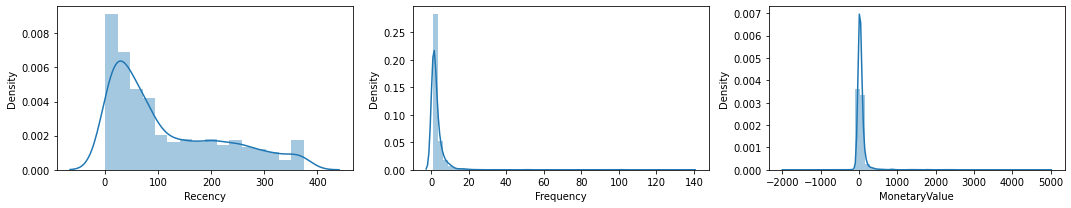

In [7]:
#Understanding the RFM Distribution

print('\033[1mRMF Variables Distribution')

n=3
nf = [i for i in customers.columns]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(customers[nf[c]])
plt.tight_layout()
plt.show()

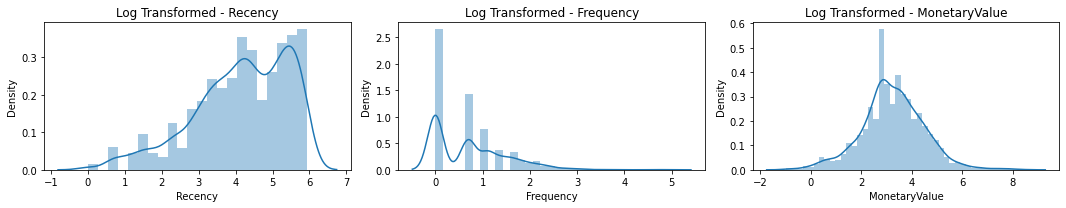

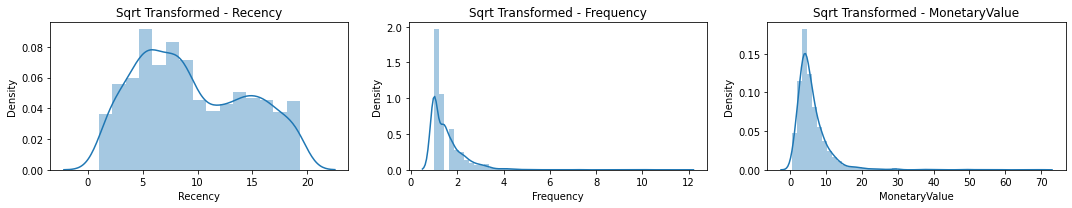

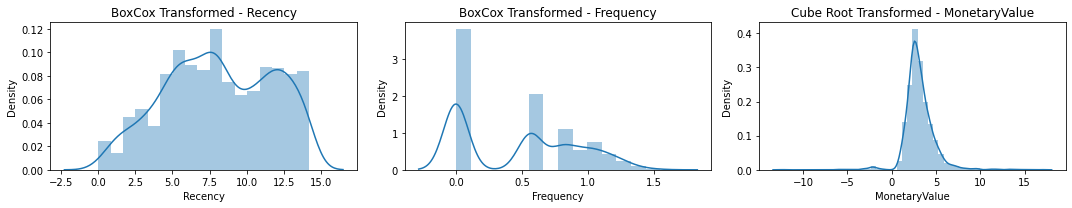

In [8]:
cutomers_logT = customers.copy(deep=True)
cutomers_sqrtT = customers.copy(deep=True)
cutomers_cbrtT = customers.copy(deep=True)
cutomers_bxcxT = customers.copy(deep=True)

for i in customers.columns:
    cutomers_logT[i] = np.log(customers[i])
    cutomers_sqrtT[i] = np.sqrt(customers[i])
    cutomers_cbrtT[i] = np.cbrt(customers[i])
    if i!='MonetaryValue':
        cutomers_bxcxT[i] = stats.boxcox(customers[i])[0]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(cutomers_logT[nf[c]])
    plt.title('Log Transformed - {}'.format(nf[c]))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(cutomers_sqrtT[nf[c]])
    plt.title('Sqrt Transformed - {}'.format(nf[c]))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)-1):
    plt.subplot(1,3,c+1)
    sns.distplot(cutomers_bxcxT[nf[c]])
    plt.title('BoxCox Transformed - {}'.format(nf[c]))
plt.subplot(1,3,3)
sns.distplot(cutomers_cbrtT[nf[2]])
plt.title('Cube Root Transformed - {}'.format(nf[2]))
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

In [9]:
#Applying the selected Transformations

customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2428,5.144506,1.021167,4.861252
2429,6.148622,0.564199,4.091635
2430,1.272970,0.798349,3.737290
2431,1.671379,1.253008,3.013275
2432,11.514709,0.000000,2.482545


# 4. Data Manipulation

In [10]:
#Applying Standardization

scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[-0. -0. -0.]
[1. 1. 1.]


# 5. Predictive Modeling

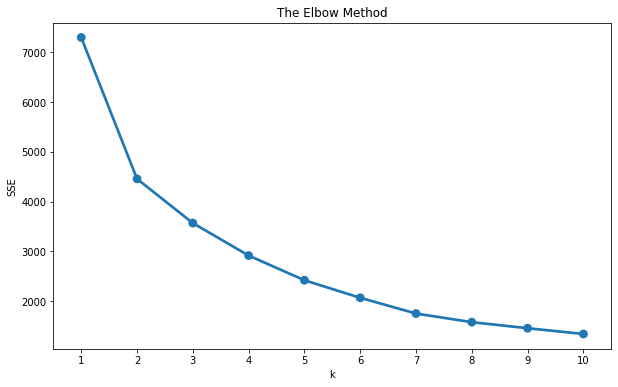

In [11]:
# Building KMeans Algorithm on the dataset

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

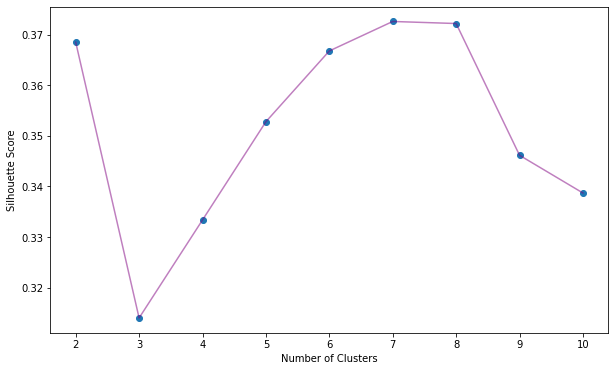

In [12]:
# Calculate silhouette score
# Full dataset
sil = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    predict=kmeans.fit_predict(customers_normalized)
    score = silhouette_score(X = customers_normalized, labels = predict)
    sil.append(score)
    
plt.plot(np.arange(2 , 11) , sil , 'o', label = "")
plt.plot(np.arange(2 , 11) , sil , '-' , alpha = 0.5, color = 'purple')
plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette Score')
plt.show()

In [13]:
#Final Model

model = KMeans(n_clusters=6, random_state=42)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        174.87      2.78         40.44   542
1        242.41      1.00         24.49   529
2         29.21      3.93         40.26   619
3         41.09     10.29        343.13   240
4         48.30      1.00         19.07   464
5        172.08      2.05        -81.40    39

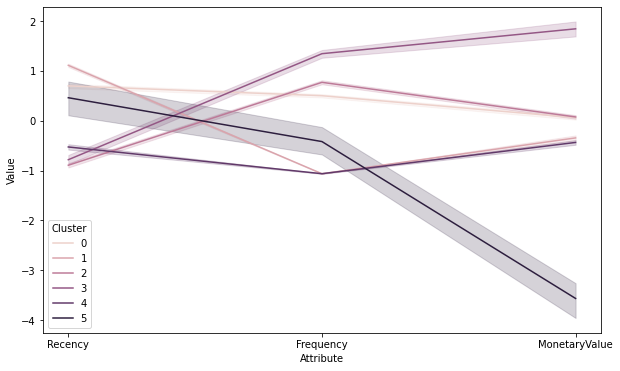

In [14]:
# Visualising the Cluster Chartecteristics

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)
plt.show()

In [15]:
def drawCluster2D(df):
    area = np.pi * (df.Frequency) ** 4

    sns.scatterplot('Recency', 'MonetaryValue', 
                   data = df, 
                   s = area, 
                   hue = 'Cluster', 
                   palette = 'spring', 
                   alpha = 0.6, 
                   edgecolor = 'darkgrey')
    plt.title('Recency / MonetaryValue (CLUSTERED)', 
              fontsize = 18)
    plt.xlabel('Recency', 
               fontsize = 16)
    plt.ylabel('MonetaryValue', 
               fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(loc = 'lower left', fontsize = 14)

    plt.savefig('2d_plot.png')
    plt.show()

In [16]:
def drawCluster3D(df):
    fig = plt.figure(1)
    plt.clf()
    ax = Axes3D(fig, 
                rect = [0, 0, .95, 1], 
                elev = 48, 
                azim = 134)

    plt.cla()
    ax.scatter(df['MonetaryValue'], df['Recency'], df['Frequency'], 
               c = df_normalized['Cluster'], 
               s = 200, 
               cmap = 'spring', 
               alpha = 0.5, 
               edgecolor = 'darkgrey')
    ax.set_xlabel('MonetaryValue', 
                  fontsize = 16)
    ax.set_ylabel('Recency', 
                  fontsize = 16)
    ax.set_zlabel('Frequency', 
                  fontsize = 16)

    plt.savefig('3d_plot.png')
    plt.show()

In [25]:
def benchCluster(estimator, name, data):
   t0 = time()
   estimator.fit(data)
   print('Name: %s \nTime: %.2fs \nInertia: %i \nDavies Bouldin score: %.3f \nCalinski harabasz score: %.3f \nSilhouette score %.3f'
      % (name, 
         (time() - t0), 
         estimator.inertia_,
         metrics.davies_bouldin_score(data, estimator.labels_),
         metrics.calinski_harabasz_score(data, estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_, metric='euclidean',sample_size=300)))

In [102]:
def benchCluster2(estimator, name, data):
   t0 = time()
   print('Name: %s \nTime: %.2fs \nDavies Bouldin score: %.3f \nCalinski harabasz score: %.3f \nSilhouette score %.3f'
      % (name, 
         (time() - t0), 
         metrics.davies_bouldin_score(data, estimator.labels_),
         metrics.calinski_harabasz_score(data, estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_)))

In [26]:
benchCluster(model, "K-means", df_normalized)

Name: K-means 
Time: 0.15s 
Inertia: 197568321 
Davies Bouldin score: 0.502 
Calinski harabasz score: 17410.399 
Silhouette score 0.542


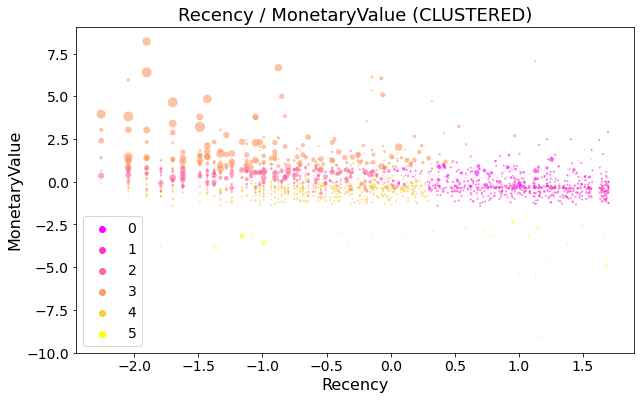

In [27]:
drawCluster2D(df_normalized)

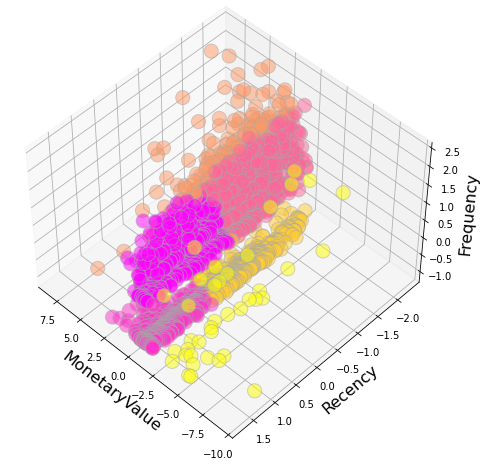

In [28]:
drawCluster3D(df_normalized)

In [31]:
# Use mini-batch k-means
model = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=100)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

Name: Mini-batch k-means 
Time: 0.16s 
Inertia: 210276420 
Davies Bouldin score: 0.496 
Calinski harabasz score: 16418.612 
Silhouette score 0.549


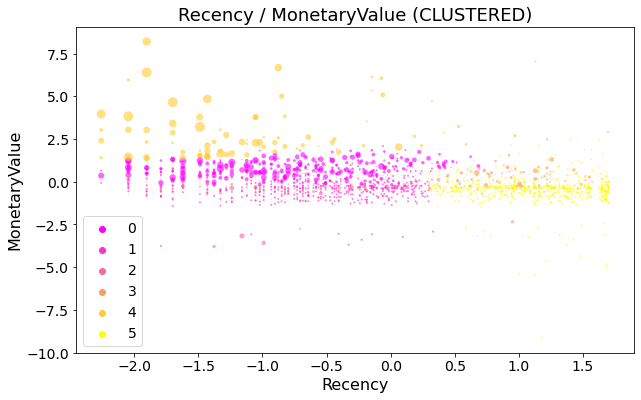

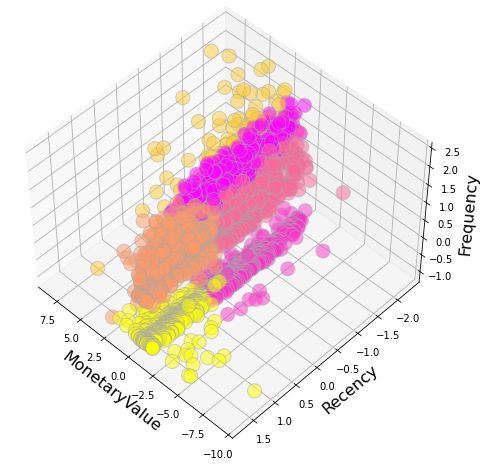

In [33]:
benchCluster(model, "Mini-batch k-means", df_normalized)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

Name: Meanshift 
Time: 0.00s 
Davies Bouldin score: 0.770 
Calinski harabasz score: 110.578 
Silhouette score 0.305


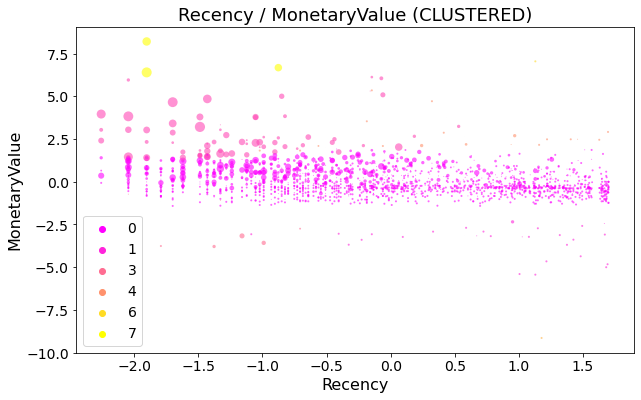

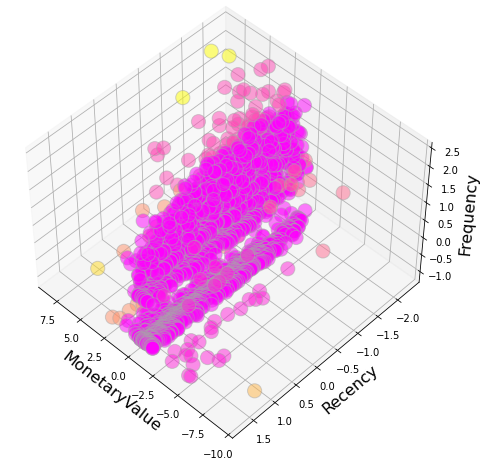

In [106]:
# Use meanshift clustering

model = MeanShift(n_jobs=-1)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

benchCluster2(model, "Meanshift", customers_normalized)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

Name: DBSCAN 
Time: 0.00s 
Davies Bouldin score: 2.785 
Calinski harabasz score: 360.317 
Silhouette score 0.229


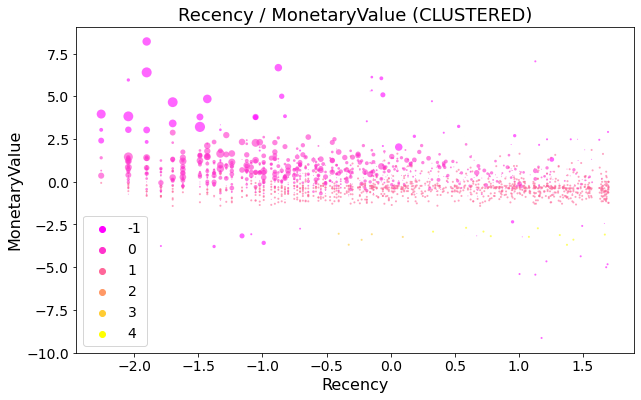

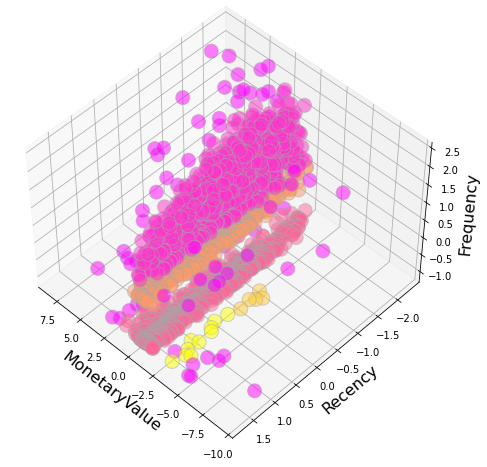

In [107]:
# Use DBSCAN clustering

model = DBSCAN(n_jobs=-1)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

benchCluster2(model, "DBSCAN", customers_normalized)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

Name: Agglomerative 
Time: 0.00s 
Davies Bouldin score: 0.842 
Calinski harabasz score: 1090.885 
Silhouette score 0.356


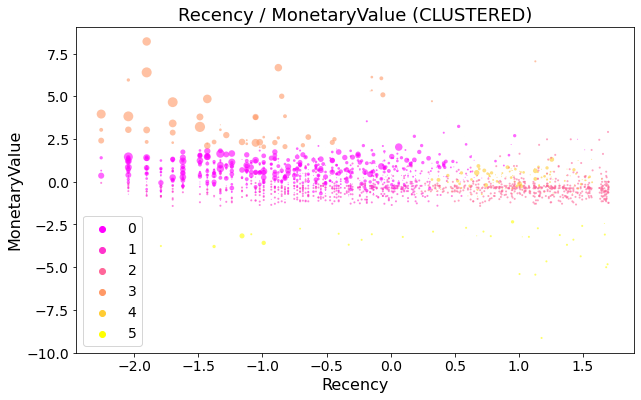

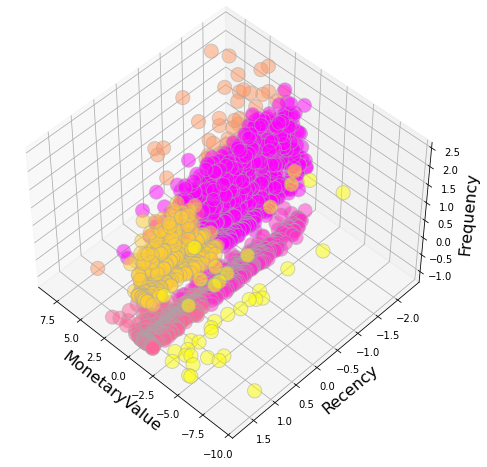

In [110]:
# Use Agglomerative clustering

model = AgglomerativeClustering(n_clusters=6)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

benchCluster2(model, "Agglomerative", customers_normalized)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)

# 6. Removing outliers

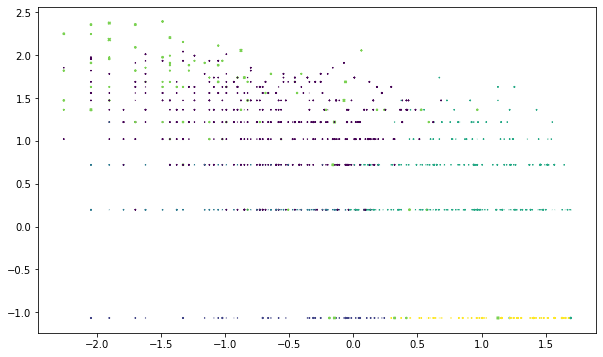

In [144]:
# kmeans model
km = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=100)
clusters=km.fit_predict(customers_normalized)
# plotting data set
plt.scatter(*zip(*customers_normalized),clusters,marker = 'x')

In [148]:
# obtaining the centers of the clusters
centroids = km.cluster_centers_
# points array will be used to reach the index easy
points = np.empty((0,len(customers_normalized[0])), float)
# distances will be used to calculate outliers
distances = np.empty((0,len(customers_normalized[0])), float)
# getting points and distances
for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],customers_normalized[clusters == i], 'euclidean')) 
    points = np.append(points, customers_normalized[clusters == i], axis=0)

In [170]:
percentile = 90
# getting outliers whose distances are greater than some percentile
outliers = points[np.where(distances > np.percentile(distances, percentile))]
others = points[np.where(distances <= np.percentile(distances, percentile))]

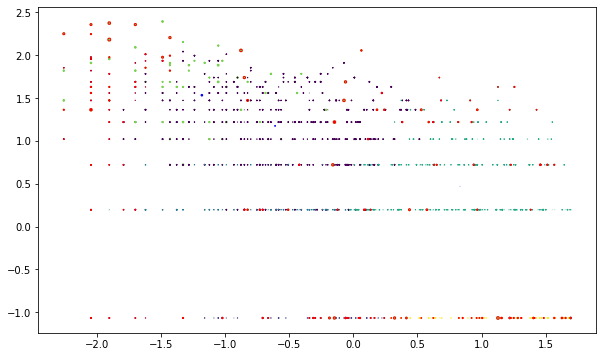

In [171]:
fig = plt.figure()
# plotting initial data
plt.scatter(*zip(*customers_normalized),c=clusters,marker = "x") 
# plotting red ovals around outlier points
plt.scatter(*zip(*outliers),marker="o",facecolor="None",edgecolor="r");
# plotting centers as blue dots
plt.scatter(*zip(*centroids),marker="o",facecolor="b",edgecolor="b");

In [172]:
others

array([[-0.64205523,  0.72085025,  0.70789438],
       [-0.24001208,  1.02081316,  0.7354544 ],
       [-1.79108501,  1.36277921,  0.77592525],
       ...,
       [ 1.55544735, -1.06585057, -0.38499357],
       [ 0.56675351, -1.06585057, -0.50116536],
       [ 0.95048863, -1.06585057, -0.37531394]])

In [173]:
df_others = pd.DataFrame(data=others, columns=["Recency", "Frequency", "MonetaryValue"])
df_others

,Recency,Frequency,MonetaryValue
0,-0.642055,0.720850,0.707894
1,-0.240012,1.020813,0.735454
2,-1.791085,1.362779,0.775925
3,0.484945,1.362779,1.188072
4,0.019609,0.196824,1.062883
...,...,...,...
2184,1.004873,-1.065851,-0.302090
2185,1.461447,-1.065851,-0.109070
2186,1.555447,-1.065851,-0.384994
2187,0.566754,-1.065851,-0.501165


Name: Mini-batch k-means 
Time: 0.14s 
Inertia: 210276420 
Davies Bouldin score: 0.496 
Calinski harabasz score: 16418.612 
Silhouette score 0.561


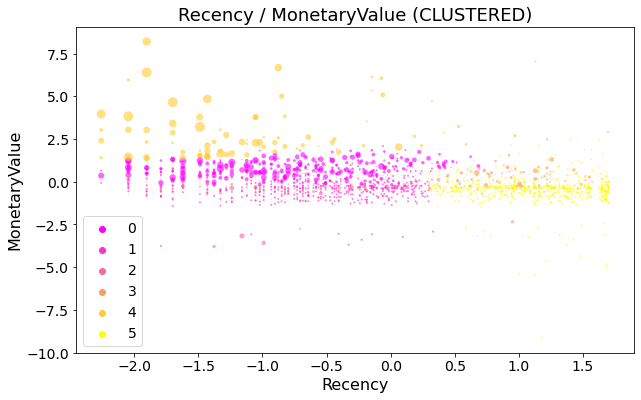

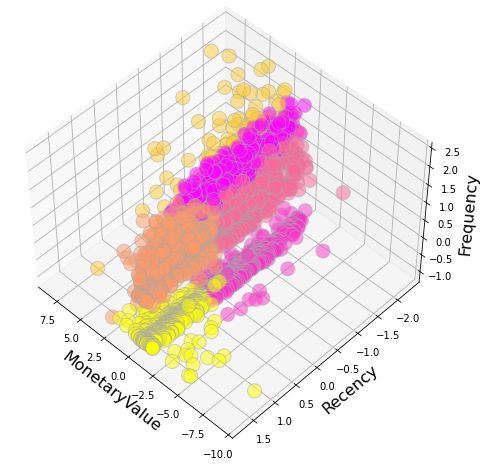

In [174]:
# Use mini-batch k-means
model = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=100)
model.fit(customers_normalized)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

benchCluster(model, "Mini-batch k-means", df_normalized)
drawCluster2D(df_normalized)
drawCluster3D(df_normalized)
#1.2% better

# 7. Conclusion